In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:.3f}".format
pd.set_option("display.max_columns", None)

### Задание 1

Загрузим данные и проведём их анализ.

In [2]:
data = pd.read_csv("kobe.csv")

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

Обратим внимание на то, что нулевые значения есть только в одном столбце (shot_made_flag). По-видимому, это и есть целевые значения, которые нужно было предсказать на соревновании. Удалим строки с нулевыми значениями, в дальнейшем оставшуюся часть данных разобьем на тренировочную и тестовую выборки.

In [4]:
data.drop(data[data["shot_made_flag"].isna()].index, inplace = True)

Посмотрим на статистические показатели выборки.

In [5]:
data.describe(include = ["number"]).T

,count,mean,std,min,25%,50%,75%,max
game_event_id,25697.000,249.349,149.779,2.000,111.000,253.000,367.000,653.000
game_id,25697.000,24741090.781,7738107.837,20000012.000,20500064.000,20900337.000,29600270.000,49900088.000
lat,25697.000,33.953,0.088,33.253,33.884,33.970,34.040,34.088
loc_x,25697.000,7.148,110.073,-250.000,-67.000,0.000,94.000,248.000
loc_y,25697.000,91.257,88.152,-44.000,4.000,74.000,160.000,791.000
lon,25697.000,-118.263,0.110,-118.520,-118.337,-118.270,-118.176,-118.022
minutes_remaining,25697.000,4.887,3.452,0.000,2.000,5.000,8.000,11.000
period,25697.000,2.521,1.152,1.000,1.000,3.000,3.000,7.000
playoffs,25697.000,0.146,0.353,0.000,0.000,0.000,0.000,1.000
seconds_remaining,25697.000,28.312,17.523,0.000,13.000,28.000,43.000,59.000


In [6]:
data.describe(exclude = ["number"]).T

,count,unique,top,freq
action_type,25697,55,Jump Shot,15836
combined_shot_type,25697,6,Jump Shot,19710
season,25697,20,2005-06,1924
shot_type,25697,2,2PT Field Goal,20285
shot_zone_area,25697,6,Center(C),11289
shot_zone_basic,25697,7,Mid-Range,10532
shot_zone_range,25697,5,Less Than 8 ft.,7857
team_name,25697,1,Los Angeles Lakers,25697
game_date,25697,1558,2016-04-13,43
matchup,25697,74,LAL @ SAS,853


Посмотрим на корреляцию цифровых параметров.

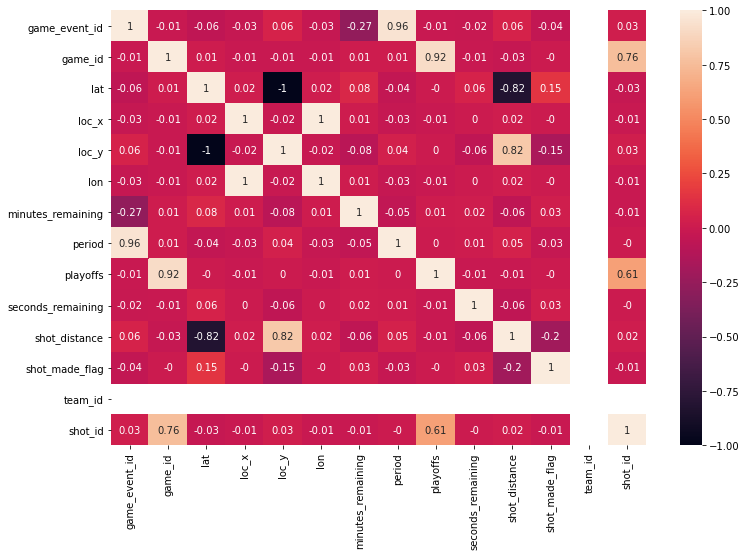

In [7]:
plt.figure(figsize = (12, 8))
sns.heatmap(data.corr().round(2), annot = True)
plt.show()

Удалим некоторые параметры, исходя из следующих соображений:
- team_id и team_name - всегда имеют одно уникальное значение, т.к. Кобе играл всю свою карьеру в одном клубе (LA Lakers);
- game_id, game_event_id, shot_id - три независимых параметра, которые не имеют отношения к тому попал Кобе в корзину или нет, данные параметры будут вносить лишь шум в нашу модель;
- lat и lon - имеют большую корреляцию с двумя другими параметрами loc_x и loc_y.

In [8]:
data.drop("team_id", axis = 1, inplace = True)
data.drop("team_name", axis = 1, inplace = True)
data.drop("game_id", axis = 1, inplace = True)
data.drop("game_event_id", axis = 1, inplace = True)
data.drop("shot_id", axis = 1, inplace = True)
data.drop("lat", axis = 1, inplace = True)
data.drop("lon", axis = 1, inplace = True)

Проверим датасет на наличие выбросов.

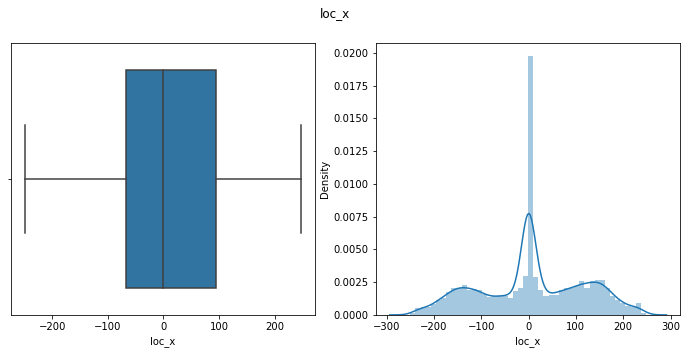

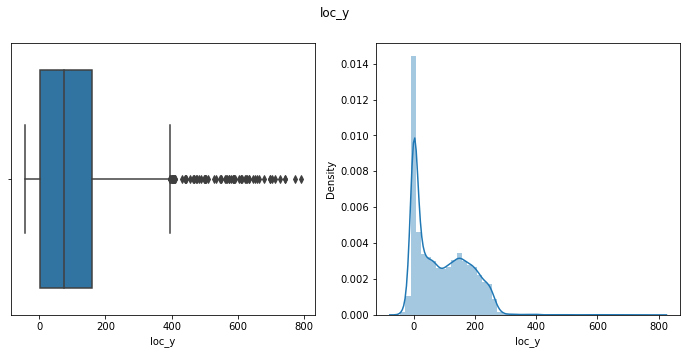

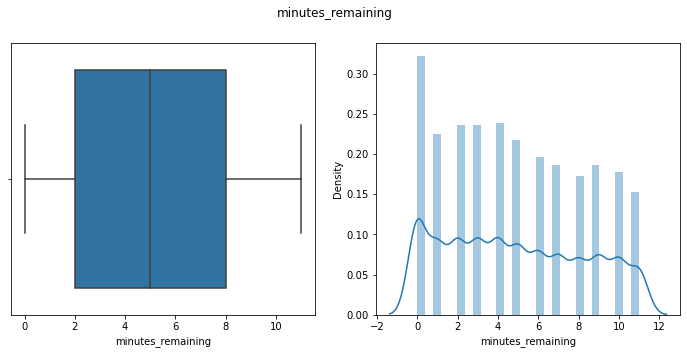

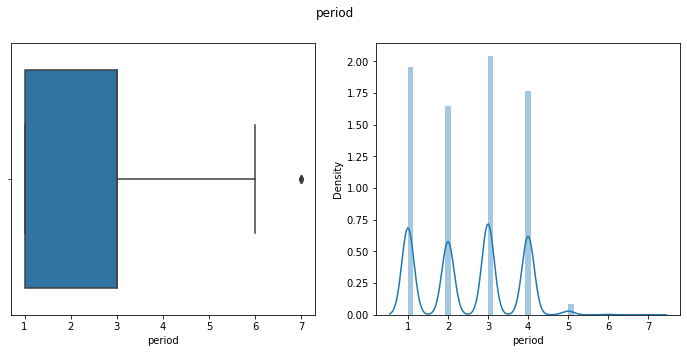

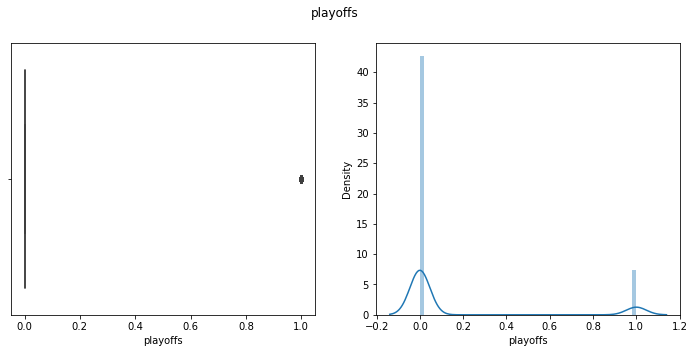

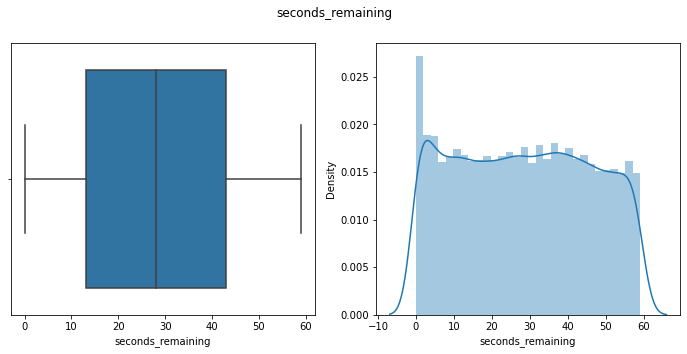

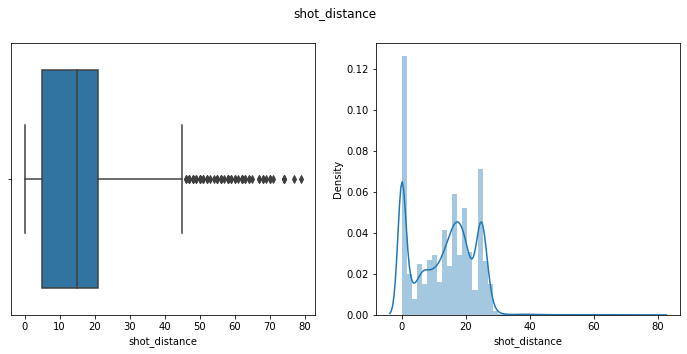

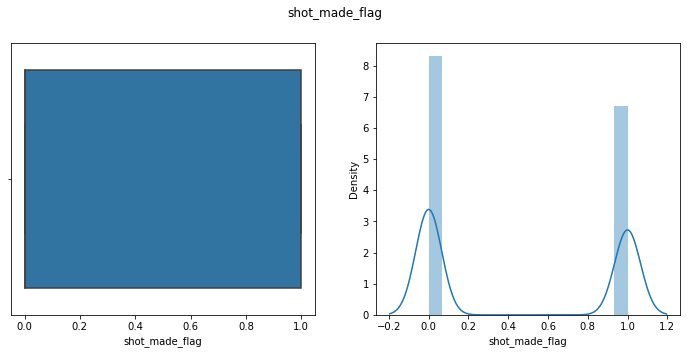

In [9]:
for col in data.select_dtypes(include = "number").columns.tolist():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))
    fig.suptitle(col)
    sns.boxplot(data[col], ax = ax1)
    sns.distplot(data[col], ax = ax2)

Боксплоты указывают, что выбросы есть у следующих признаков:
- playoffs - выбросов нет, даже несмотря на неравномерное распределение. Для баскетбола это вполне объяснимый результат, т.к. матчей регулярного сезона больше, чем матчей плей-офф;
- periods - также нету выбросов, несмотря на то что в НБА всего 4 периода. Возможно Кобе принимал участие в ОИ или других международных турнирах, где регламент проведения матчей отличался.
- loc_y и shot_distance - также выбросов не наблюдается. Из хитмэпа мы можем видеть, что эти параметры сильно коррелируемы между собой, а дистанция примерно в 25-30 метров вполне допустима в ситуации броска со своей половины в конце матча.

По итогу принимаем решения ничего не очищать.

Похоже, что minutes_remaining и seconds_remaining являются составными частями одного целого, поэтому объединим их.

In [10]:
data["remaining_time"] = data["minutes_remaining"] * 60 + data["seconds_remaining"]

data.drop("minutes_remaining", axis = 1, inplace = True)
data.drop("seconds_remaining", axis = 1, inplace = True)

Вычленим из game_date год игры и месяц.

In [11]:
data["game_year"] = pd.to_datetime(data["game_date"]).dt.year
data["game_month"] = pd.to_datetime(data["game_date"]).dt.month

data.drop("game_date", axis = 1, inplace = True)

Создадим новый параметр, обозначающий домашний матч (1) или матч на выезде (0).

In [12]:
data["home_play"] = data["matchup"].str.contains("vs").astype("int")

data.drop("matchup", axis = 1, inplace = True) 

Вручную проиндексируем следующие признаки:

In [13]:
data.select_dtypes(exclude = "number").nunique()

action_type           55
combined_shot_type     6
season                20
shot_type              2
shot_zone_area         6
shot_zone_basic        7
shot_zone_range        5
opponent              33
dtype: int64

In [14]:
features = ["action_type", "season", "opponent"]

for feature in features:
    data[feature] = data[feature].astype("category").cat.codes
    
features = ["combined_shot_type", "shot_type", "shot_zone_area", "shot_zone_basic", "shot_zone_range"]

for feature in features:
    dummies = pd.get_dummies(data[feature])
    dummies = dummies.add_prefix("{}#".format(feature))
    data.drop(feature, axis=1, inplace=True)
    data = data.join(dummies)

Подготовим наши данные для проверки моделей.

In [15]:
X = data[data.columns.difference(["shot_made_flag"])]
Y = data["shot_made_flag"].astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)

In [16]:
logistic = make_pipeline(StandardScaler(), LogisticRegression(solver = "lbfgs", max_iter = 1000))
lasso = Lasso()
ridge = Ridge()

logistic.fit(X_train, Y_train)
lasso.fit(X_train, Y_train)
ridge.fit(X_train, Y_train)

print("Logistic Score:", round(logistic.score(X_train, Y_train), 4))
print("Lasso Score:", round(lasso.score(X_train, Y_train), 4))
print("Ridge Score:", round(ridge.score(X_train, Y_train), 4))

Logistic Score: 0.621
Lasso Score: 0.0228
Ridge Score: 0.0722


Построим сравнительную таблицу коэффициентов.

In [17]:
logistic_coef = logistic["logisticregression"].coef_[0]
lasso_coef = lasso.coef_
ridge_coef = ridge.coef_

features = list(X.columns)
columns = ["Feature", "Logistic", "Lasso", "Ridge"]

pd.DataFrame(data = np.array([features, logistic_coef, lasso_coef, ridge_coef]).T, columns = columns)

,Feature,Logistic,Lasso,Ridge
0,action_type,0.0998752520487836,0.0,0.0022386867020003248
1,combined_shot_type#Bank Shot,0.072205206566691,0.0,0.18717621198967854
2,combined_shot_type#Dunk,0.45482986299888933,0.0,0.331641134093999
3,combined_shot_type#Hook Shot,-0.004436032987870093,0.0,-0.05043162723848871
4,combined_shot_type#Jump Shot,-0.23931778975961207,-0.0,-0.1750357275391363
5,combined_shot_type#Layup,0.032867077523427046,0.0,-0.015484637651527624
6,combined_shot_type#Tip Shot,-0.07769760393605109,-0.0,-0.2778653536682824
7,game_month,-0.01451034215635816,-0.0,-0.00042202813023340096
8,game_year,0.011831596440217603,-0.0,0.004339235608507869
9,home_play,0.03066359793430062,0.0,0.013771996577783616


Как видно, модель lasso занулила все коэфициенты, logistic и ridge нет. В целом, исходя из скора, модели lasso и ridge показали себя очень плохо. Возможно, для данного датасета эти модели не подходят. В нашем датасете немного параметров 37 и в большинстве они слабокоррелируемы. В то время как регрессия LASSO и ридж-регрессия подходят больше для наборов данных с большим количеством признаков, которые являются зависимыми друг от друга.

Вычислим ROC AUC метрику.

In [18]:
predict_logistic = logistic.predict(X_test)
predict_lasso = lasso.predict(X_test)
predict_ridge = ridge.predict(X_test)

print("Logistic ROC AUC:", round(roc_auc_score(Y_test, predict_logistic), 4))
print("Lasso ROC AUC:", round(roc_auc_score(Y_test, predict_lasso), 4))
print("Ridge ROC AUC:", round(roc_auc_score(Y_test, predict_ridge), 4))

Logistic ROC AUC: 0.5897
Lasso ROC AUC: 0.5817
Ridge ROC AUC: 0.6286


Построим PCA.

Text(0, 0.5, 'Cumulative explained variance')

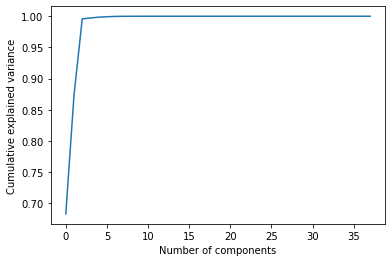

In [19]:
pca = PCA().fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")